In [2]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import torch
import matplotlib.pyplot as plt

In [3]:

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:

#model.save_pretrained(MODEL)
text = "I love you, but I hate you."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")


1) negative 0.7203
2) neutral 0.2415
3) positive 0.0383


In [16]:
def analyse(model,text):
    #model.save_pretrained(MODEL)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores

In [11]:
# load the json file
import json
with open('interstellar.json') as json_file:
    data = json.load(json_file)

In [12]:
print(scores)

None


In [32]:
x = []
neg = []
pos = []

window = 30
subs = []
for sub in data:
  subs.append(sub)
  start = sub[0]
  while start - subs[0][0] > window:
    txt = str.join(" ", [s[2] for s in subs[:-1]])
    scores = analyse(model, txt)
    x.append(subs[0][0])
    neg.append(scores[0])
    pos.append(scores[2])
    subs.pop(0)

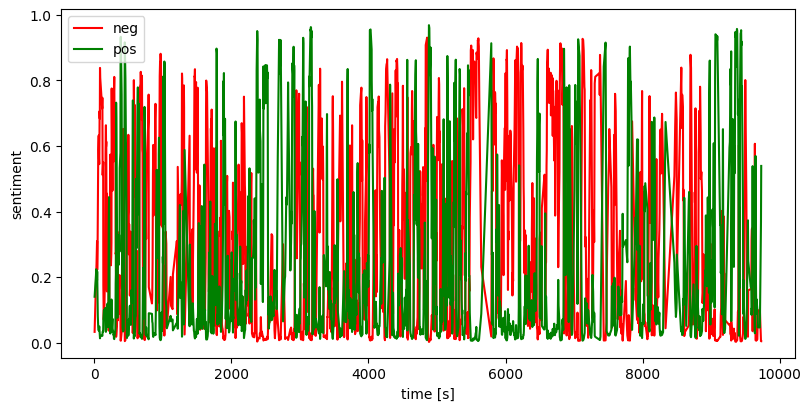

In [33]:
plt.figure(figsize=(8, 4), layout='constrained')
plt.plot(x, neg, color="red", label="neg")
plt.plot(x, pos, color="green", label="pos")
plt.xlabel("time [s]")
plt.ylabel("sentiment")
plt.legend()

In [34]:
diff = []
for i in range(len(x)):
    diff.append(pos[i] - neg[i])

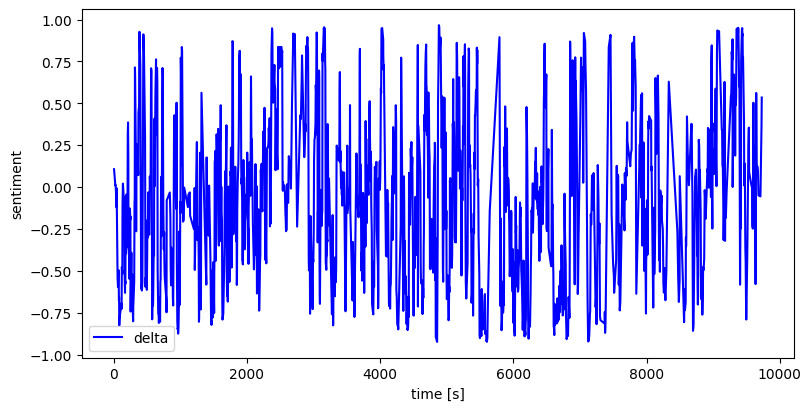

In [35]:
plt.figure(figsize=(8, 4), layout='constrained')
plt.plot(x, diff, color="blue", label="delta")
plt.xlabel("time [s]")
plt.ylabel("sentiment")
plt.legend()

In [36]:
def moving_average(x, width):
    return np.convolve(x, np.ones(width), 'valid') / width

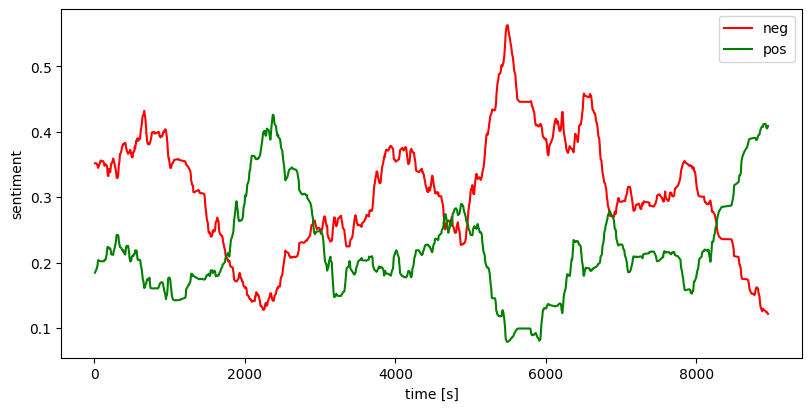

In [37]:
width = 128
avgNeg = moving_average(neg, width)
avgPos = moving_average(pos, width)
plt.figure(figsize=(8, 4), layout='constrained')
plt.plot(x[:len(avgNeg)], avgNeg, color="red", label="neg")
plt.plot(x[:len(avgPos)], avgPos, color="green", label="pos")
plt.xlabel("time [s]")
plt.ylabel("sentiment")
plt.legend()

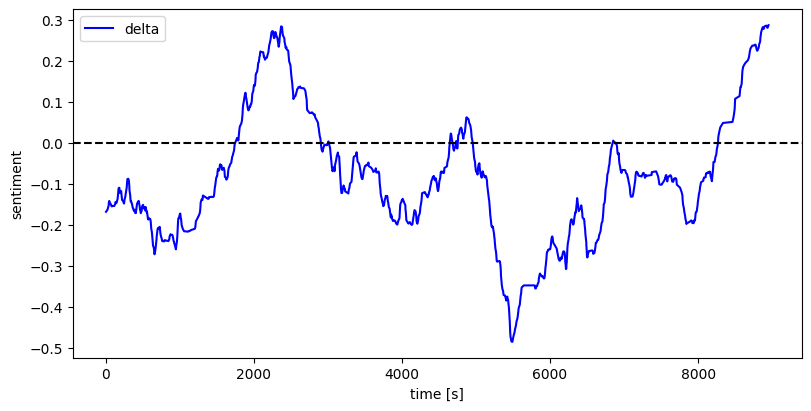

In [38]:
diff = []
for i in range(len(avgPos)):
    diff.append(avgPos[i] - avgNeg[i])
plt.figure(figsize=(8, 4), layout='constrained')
plt.plot(x[:len(avgPos)], diff, color="blue", label="delta")
plt.axhline(y=0, color="black", linestyle='--')
plt.xlabel("time [s]")
plt.ylabel("sentiment")
plt.legend()

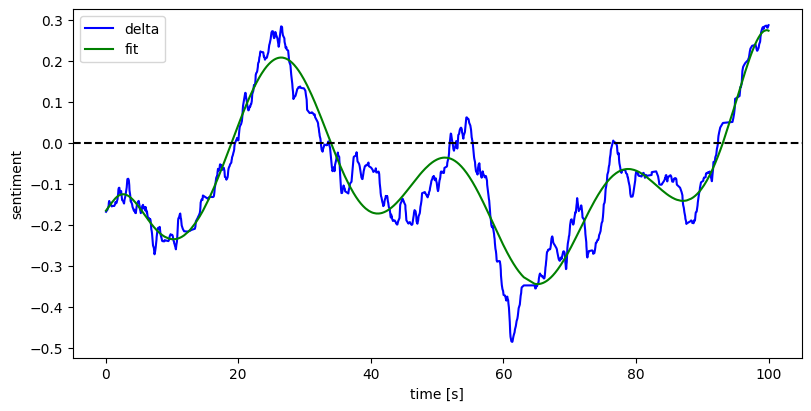

In [52]:
realX = x[:len(avgPos)]
factor = 100 / realX[-1]
normx = [r * factor for r in realX]
order = 16
fit = list(np.polyfit(normx, diff, order))
fit.reverse()
func = [sum([val**i * fit[i] for i in range(len(fit))]) for val in normx]

plt.figure(figsize=(8, 4), layout='constrained')
plt.plot(normx, diff, color="blue", label="delta")
plt.plot(normx, func, color="green", label="fit")
plt.axhline(y=0, color="black", linestyle='--')
plt.xlabel("time [s]")
plt.ylabel("sentiment")
plt.legend()

In [57]:
print(["{c:.2e}".format(c=c) for c in fit])

['-1.66e-01', '1.86e-02', '8.53e-03', '-6.25e-03', '1.31e-03', '-1.49e-04', '1.10e-05', '-5.58e-07', '2.00e-08', '-5.15e-10', '9.60e-12', '-1.29e-13', '1.25e-15', '-8.45e-18', '3.78e-20', '-1.01e-22', '1.21e-25']
